# Momentum-Variance Phase Space

The AdamW update rule determines whether a token can hop:

$$\Delta W = \frac{\eta \cdot m}{\sqrt{v} + \epsilon}$$

A token hops when |ΔW| ≥ ULP. The critical boundary is:

$$|m| = \frac{\text{ULP} \cdot (\sqrt{v} + \epsilon)}{\eta}$$

This notebook visualizes dead token dynamics in (m, v) phase space to see how tokens cross this boundary into Fimbulwinter.

**Input:** `box_4/tensors/Thimble-8/thimble_8_trajectory.safetensors`

## Parameters

In [11]:
# Paths
TRAJECTORY_PATH = '../../tensors/Thimble-8/thimble_8_trajectory.safetensors'

# AdamW hyperparameters (from Thimble 8 training)
ETA = 3e-4       # learning rate
EPSILON = 1e-8   # Adam epsilon

# Plotting
DPI = 150
FIGSIZE = (12, 8)
FIGSIZE_WIDE = (14, 6)

## Imports

In [12]:
import torch
from safetensors.torch import load_file
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

## Load Data

In [13]:
data = load_file(TRAJECTORY_PATH)

# W is stored as uint16 (bfloat16 bit pattern)
W = data['W'].view(torch.bfloat16)  # (4001, 3699, 64)
m = data['m']  # (4001, 3699, 64) float32 - momentum
v = data['v']  # (4001, 3699, 64) float32 - variance

n_steps_plus_one, n_tokens, n_dims = W.shape
n_steps = n_steps_plus_one - 1  # 4000 training steps, index 0 is initial state

print(f"W shape: {W.shape}")
print(f"m shape: {m.shape}")
print(f"v shape: {v.shape}")
print(f"Training steps: {n_steps}")

W shape: torch.Size([4001, 3699, 64])
m shape: torch.Size([4001, 3699, 64])
v shape: torch.Size([4001, 3699, 64])
Training steps: 4000


## Compute ULP for W

We need ULP at each position to determine the critical boundary.

In [14]:
def compute_ulp_bf16(tensor_bf16: torch.Tensor) -> torch.Tensor:
    """Compute ULP for each element of a bfloat16 tensor."""
    bits = tensor_bf16.view(torch.uint16).to(torch.int32)
    exponent = (bits >> 7) & 0xFF
    effective_exp = torch.where(exponent == 0, torch.ones_like(exponent), exponent)
    ulp = torch.pow(2.0, (effective_exp - 134).float())
    return ulp

# ULP at each position (we'll use W[:-1] to match with updates)
# Shape: (4000, 3699, 64)
ulp = compute_ulp_bf16(W[:-1])
print(f"ULP shape: {ulp.shape}")
print(f"ULP range: [{ulp.min():.2e}, {ulp.max():.2e}]")

ULP shape: torch.Size([4000, 3699, 64])
ULP range: [9.18e-41, 9.77e-04]


## Compute Predicted Update Magnitude

The AdamW update (ignoring bias correction for now):
$$|\Delta W|_{\text{predicted}} = \frac{\eta \cdot |m|}{\sqrt{v} + \epsilon}$$

In [15]:
# Use m and v from steps 1 onwards (after first optimizer step)
# These correspond to the state AFTER step t, used to compute update for step t+1
# But actually m[t] and v[t] are the state after step t's update
# For the update at step t, we use m[t] and v[t]

m_for_update = m[1:]  # (4000, 3699, 64) - state after each step
v_for_update = v[1:]  # (4000, 3699, 64)

# Predicted update magnitude in absolute units
delta_W_predicted = ETA * m_for_update.abs() / (torch.sqrt(v_for_update) + EPSILON)

# Convert to lattice units (divide by ULP)
delta_W_predicted_lattice = delta_W_predicted / ulp

print(f"Predicted ΔW (lattice units) shape: {delta_W_predicted_lattice.shape}")
print(f"Range: [{delta_W_predicted_lattice.min():.4f}, {delta_W_predicted_lattice.max():.4f}]")

Predicted ΔW (lattice units) shape: torch.Size([4000, 3699, 64])
Range: [0.0000, 20694085474328789063230313135477882880.0000]


## Collapse Across Dimensions

For visualization, we'll look at representative scalars per token per timestep.
Take the L2 norm across dimensions for |m| and mean for v.

In [16]:
# Per-token, per-timestep scalar summaries
# |m|: L2 norm across dimensions
m_norm = torch.norm(m_for_update, dim=2)  # (4000, 3699)

# v: mean across dimensions (variance is always positive)
v_mean = v_for_update.mean(dim=2)  # (4000, 3699)

# sqrt(v) for the denominator
sqrt_v_mean = torch.sqrt(v_mean)

# Mean ULP per token (geometric mean might be better but arithmetic is fine)
ulp_mean = ulp.mean(dim=2)  # (4000, 3699)

print(f"|m| norm shape: {m_norm.shape}")
print(f"|m| range: [{m_norm.min():.2e}, {m_norm.max():.2e}]")
print(f"v mean range: [{v_mean.min():.2e}, {v_mean.max():.2e}]")

|m| norm shape: torch.Size([4000, 3699])
|m| range: [3.75e-05, 1.07e-03]
v mean range: [2.19e-12, 1.33e-09]


## The Critical Boundary

A token hops when:
$$\frac{\eta \cdot |m|}{\sqrt{v} + \epsilon} \geq \text{ULP}$$

The boundary curve (|ΔW| = 1 ULP) is:
$$|m| = \frac{\text{ULP} \cdot (\sqrt{v} + \epsilon)}{\eta}$$

In [17]:
def critical_m(sqrt_v, ulp_val, eta=ETA, eps=EPSILON):
    """Critical |m| value for hopping given sqrt(v) and ULP."""
    return ulp_val * (sqrt_v + eps) / eta

# For plotting, we'll use a representative ULP (median across all positions)
ulp_representative = ulp_mean.median().item()
print(f"Representative ULP: {ulp_representative:.2e}")

# Create the critical curve for plotting
sqrt_v_range = np.logspace(-10, -2, 100)
m_critical = critical_m(sqrt_v_range, ulp_representative)

print(f"Critical |m| at sqrt(v)=1e-6: {critical_m(1e-6, ulp_representative):.2e}")
print(f"Critical |m| at sqrt(v)=1e-4: {critical_m(1e-4, ulp_representative):.2e}")

Representative ULP: 3.85e-04
Critical |m| at sqrt(v)=1e-6: 1.30e-06
Critical |m| at sqrt(v)=1e-4: 1.28e-04


## Visualization 1: Scatter Plot with Critical Boundary

Plot tokens in (√v, |m|) space at different timesteps, colored by whether they hopped.

In [18]:
# Load actual displacements to determine who hopped
displacement_data = load_file('../../tensors/Thimble-8/lattice_displacement.safetensors')
delta_W_prime = displacement_data['delta_W_prime']  # (4000, 3699, 64)
displacement_magnitude = torch.norm(delta_W_prime, dim=2)  # (4000, 3699)

hopped = displacement_magnitude >= 1.0  # Did token hop at least 1 lattice cell?
print(f"Hop fraction overall: {hopped.float().mean():.1%}")

Hop fraction overall: 39.4%


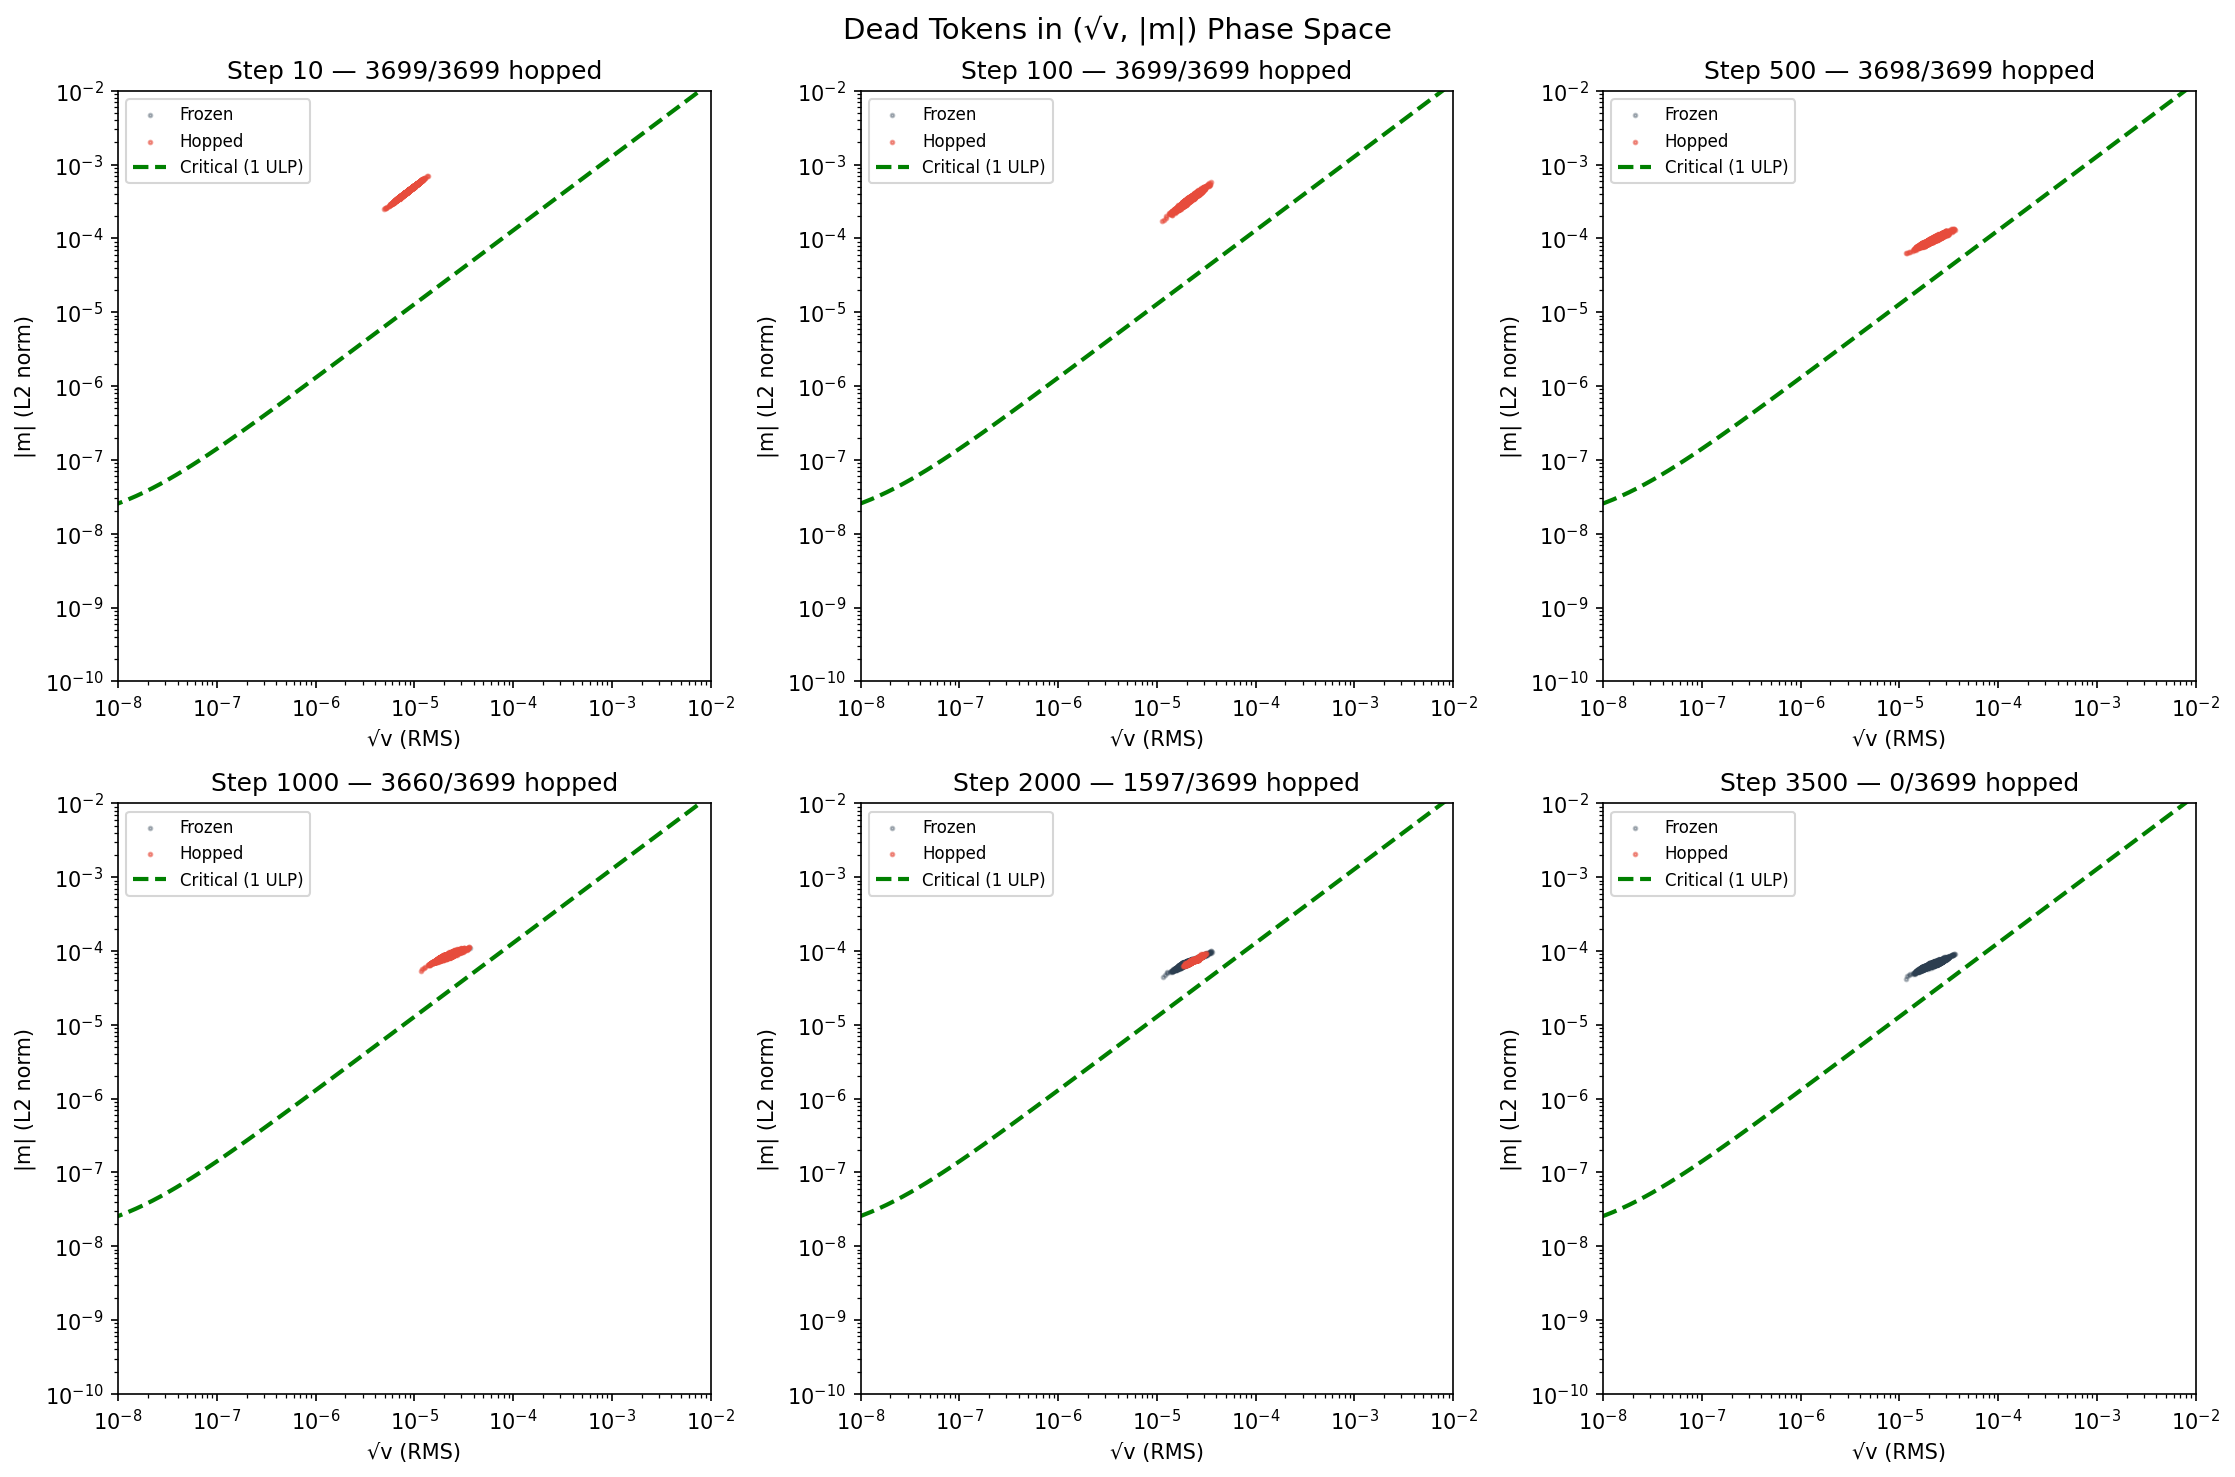

In [19]:
# Pick a few representative timesteps
timesteps_to_plot = [10, 100, 500, 1000, 2000, 3500]

fig, axes = plt.subplots(2, 3, figsize=(15, 10), dpi=DPI)
axes = axes.flatten()

for ax, t in zip(axes, timesteps_to_plot):
    # Get data for this timestep (t is 1-indexed in our mental model, 0-indexed in arrays)
    t_idx = t - 1
    
    sqrt_v_t = sqrt_v_mean[t_idx].numpy()
    m_norm_t = m_norm[t_idx].numpy()
    hopped_t = hopped[t_idx].numpy()
    
    # Plot frozen tokens (didn't hop)
    ax.scatter(sqrt_v_t[~hopped_t], m_norm_t[~hopped_t], 
               c='#2c3e50', s=3, alpha=0.3, label='Frozen')
    # Plot hopping tokens
    ax.scatter(sqrt_v_t[hopped_t], m_norm_t[hopped_t], 
               c='#e74c3c', s=3, alpha=0.5, label='Hopped')
    
    # Critical boundary
    ax.plot(sqrt_v_range, m_critical, 'g--', linewidth=2, label='Critical (1 ULP)')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('√v (RMS)')
    ax.set_ylabel('|m| (L2 norm)')
    ax.set_title(f'Step {t} — {hopped_t.sum()}/{len(hopped_t)} hopped')
    ax.legend(loc='upper left', fontsize=8)
    ax.set_xlim(1e-8, 1e-2)
    ax.set_ylim(1e-10, 1e-2)

plt.suptitle('Dead Tokens in (√v, |m|) Phase Space', fontsize=14)
plt.tight_layout()
plt.show()

## Visualization 2: Token Trajectories Through Phase Space

Track individual tokens as they evolve through (√v, |m|) space over training.

In [20]:
# Select a few tokens with different behaviors
np.random.seed(42)

# Find last hop step for each token
last_hop_step = torch.zeros(n_tokens)
for i in range(n_tokens):
    hop_steps = torch.where(hopped[:, i])[0]
    if len(hop_steps) > 0:
        last_hop_step[i] = hop_steps[-1].item()
    else:
        last_hop_step[i] = -1

# Use percentiles to define categories (guarantees we have tokens in each)
valid_last_hops = last_hop_step[last_hop_step >= 0]
p25 = torch.quantile(valid_last_hops, 0.25).item()
p75 = torch.quantile(valid_last_hops, 0.75).item()

print(f"Last hop step distribution:")
print(f"  Min: {valid_last_hops.min().item():.0f}")
print(f"  25th percentile: {p25:.0f}")
print(f"  75th percentile: {p75:.0f}")
print(f"  Max: {valid_last_hops.max().item():.0f}")

# Categorize based on percentiles
early_freezers = torch.where((last_hop_step >= 0) & (last_hop_step <= p25))[0]
mid_freezers = torch.where((last_hop_step > p25) & (last_hop_step <= p75))[0]
late_freezers = torch.where(last_hop_step > p75)[0]

print(f"\nEarly freezers (≤ {p25:.0f}): {len(early_freezers)}")
print(f"Mid freezers ({p25:.0f}-{p75:.0f}): {len(mid_freezers)}")
print(f"Late freezers (> {p75:.0f}): {len(late_freezers)}")

# Pick one from each category
sample_tokens = [
    early_freezers[np.random.randint(len(early_freezers))].item(),
    mid_freezers[np.random.randint(len(mid_freezers))].item(),
    late_freezers[np.random.randint(len(late_freezers))].item(),
]
print(f"\nSampled tokens: {sample_tokens}")

Last hop step distribution:
  Min: 1605
  25th percentile: 2069
  75th percentile: 3721
  Max: 3997

Early freezers (≤ 2069): 926
Mid freezers (2069-3721): 2152
Late freezers (> 3721): 621

Sampled tokens: [445, 1453, 1546]


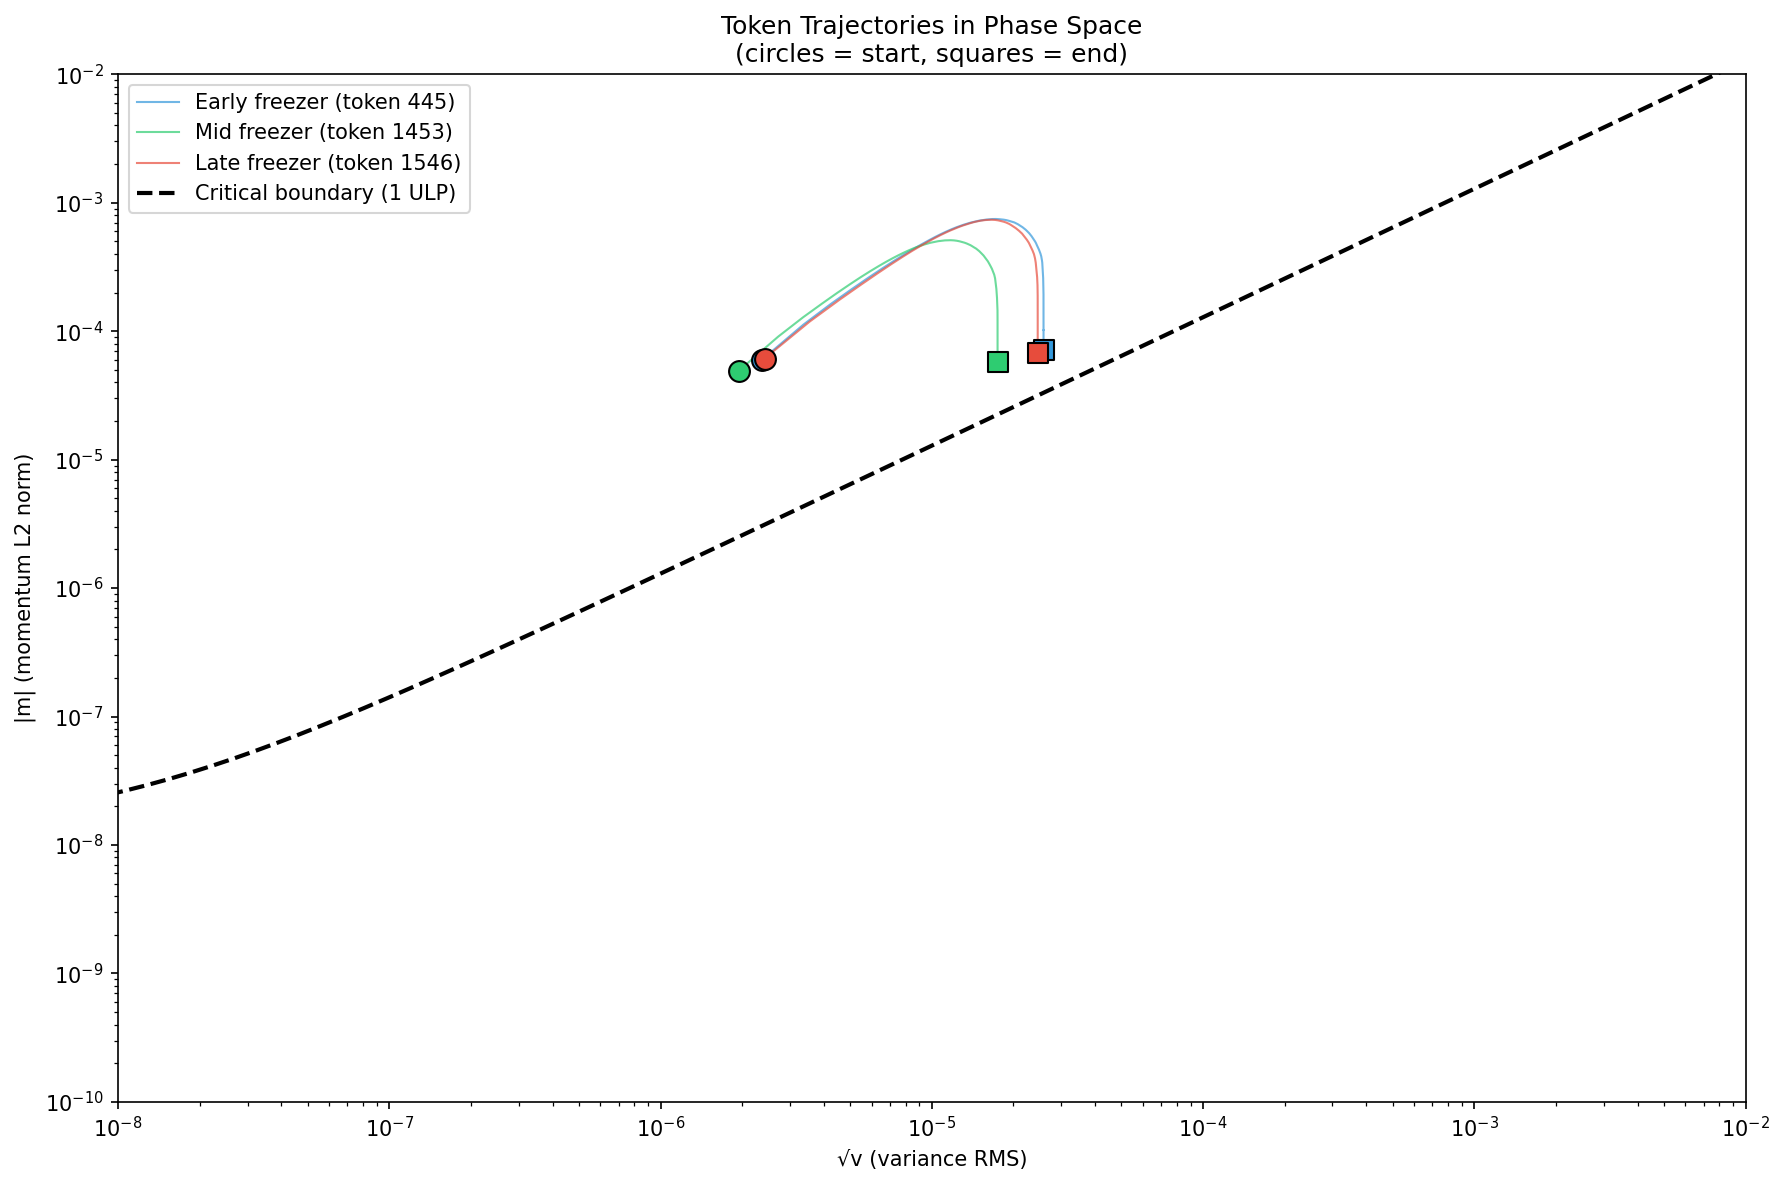

In [21]:
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

colors = ['#3498db', '#2ecc71', '#e74c3c']
labels = ['Early freezer', 'Mid freezer', 'Late freezer']

for token_idx, color, label in zip(sample_tokens, colors, labels):
    sqrt_v_traj = sqrt_v_mean[:, token_idx].numpy()
    m_norm_traj = m_norm[:, token_idx].numpy()
    
    # Plot trajectory
    ax.plot(sqrt_v_traj, m_norm_traj, c=color, alpha=0.7, linewidth=1, label=f'{label} (token {token_idx})')
    
    # Mark start and end
    ax.scatter(sqrt_v_traj[0], m_norm_traj[0], c=color, s=100, marker='o', edgecolors='black', zorder=5)
    ax.scatter(sqrt_v_traj[-1], m_norm_traj[-1], c=color, s=100, marker='s', edgecolors='black', zorder=5)

# Critical boundary
ax.plot(sqrt_v_range, m_critical, 'k--', linewidth=2, label='Critical boundary (1 ULP)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('√v (variance RMS)')
ax.set_ylabel('|m| (momentum L2 norm)')
ax.set_title('Token Trajectories in Phase Space\n(circles = start, squares = end)')
ax.legend(loc='upper left')
ax.set_xlim(1e-8, 1e-2)
ax.set_ylim(1e-10, 1e-2)

plt.tight_layout()
plt.show()

## Visualization 3: Phase Diagram Density

Where do tokens live in phase space at different training stages?

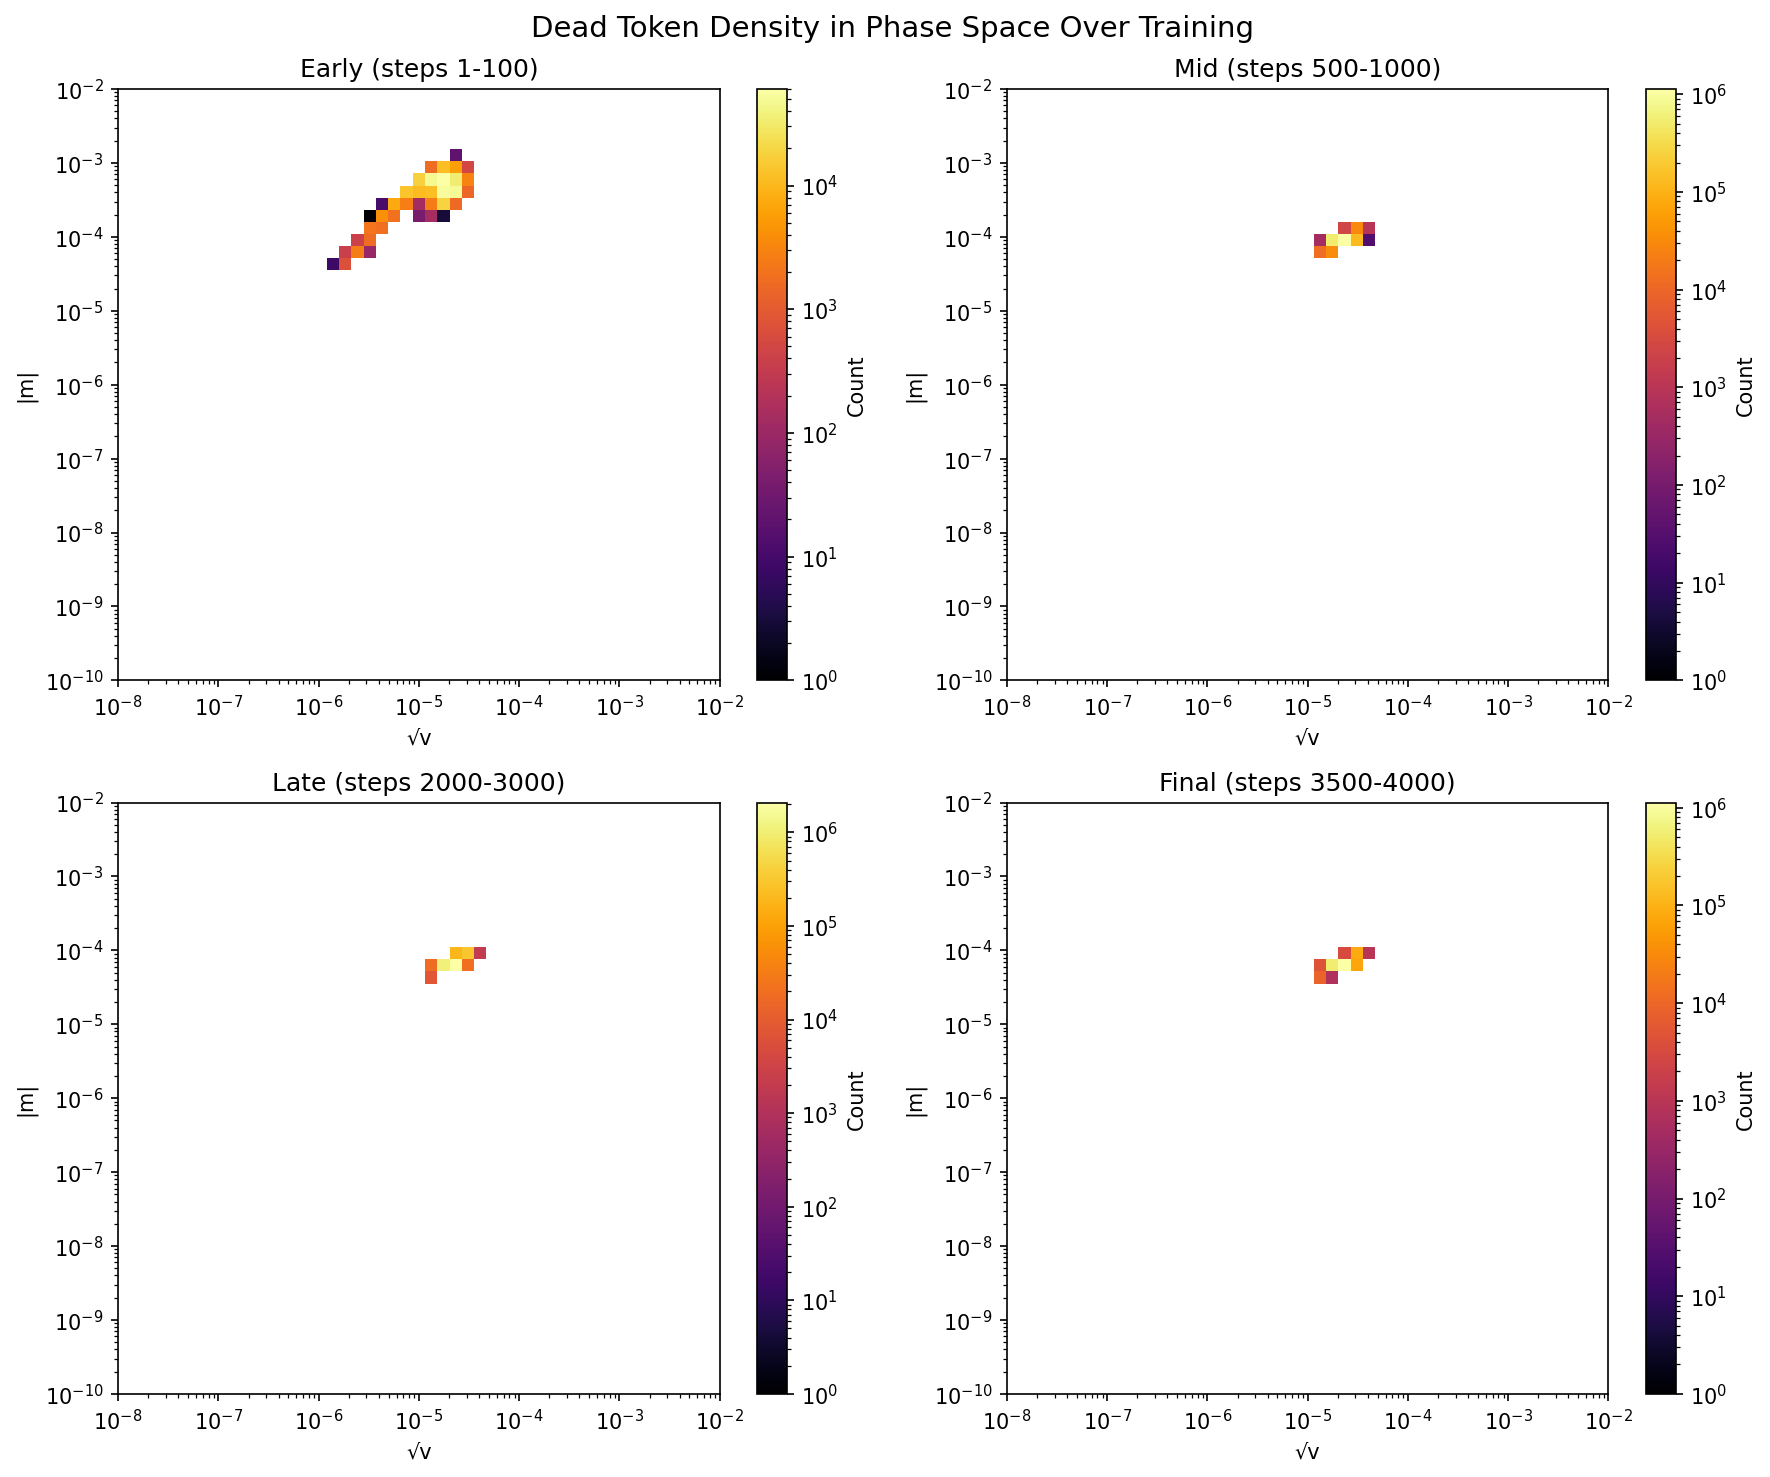

In [22]:
# Create 2D histograms for different training phases
phases = [
    ('Early (steps 1-100)', 0, 100),
    ('Mid (steps 500-1000)', 499, 1000),
    ('Late (steps 2000-3000)', 1999, 3000),
    ('Final (steps 3500-4000)', 3499, 4000),
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=DPI)
axes = axes.flatten()

# Bin edges (log-spaced)
sqrt_v_bins = np.logspace(-8, -2, 50)
m_bins = np.logspace(-10, -2, 50)

for ax, (phase_name, t_start, t_end) in zip(axes, phases):
    # Gather all (sqrt_v, m) points in this time window
    sqrt_v_phase = sqrt_v_mean[t_start:t_end].flatten().numpy()
    m_norm_phase = m_norm[t_start:t_end].flatten().numpy()
    
    # 2D histogram
    h, xedges, yedges = np.histogram2d(
        sqrt_v_phase, m_norm_phase,
        bins=[sqrt_v_bins, m_bins]
    )
    
    # Plot
    im = ax.pcolormesh(xedges, yedges, h.T, cmap='inferno', norm=LogNorm(vmin=1, vmax=h.max()))
    
    # Critical boundary
    ax.plot(sqrt_v_range, m_critical, 'w--', linewidth=2, label='Critical (1 ULP)')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('√v')
    ax.set_ylabel('|m|')
    ax.set_title(phase_name)
    ax.set_xlim(1e-8, 1e-2)
    ax.set_ylim(1e-10, 1e-2)
    plt.colorbar(im, ax=ax, label='Count')

plt.suptitle('Dead Token Density in Phase Space Over Training', fontsize=14)
plt.tight_layout()
plt.show()

## Visualization 4: Distance to Critical Boundary Over Time

How far above/below the critical line are tokens, on average?

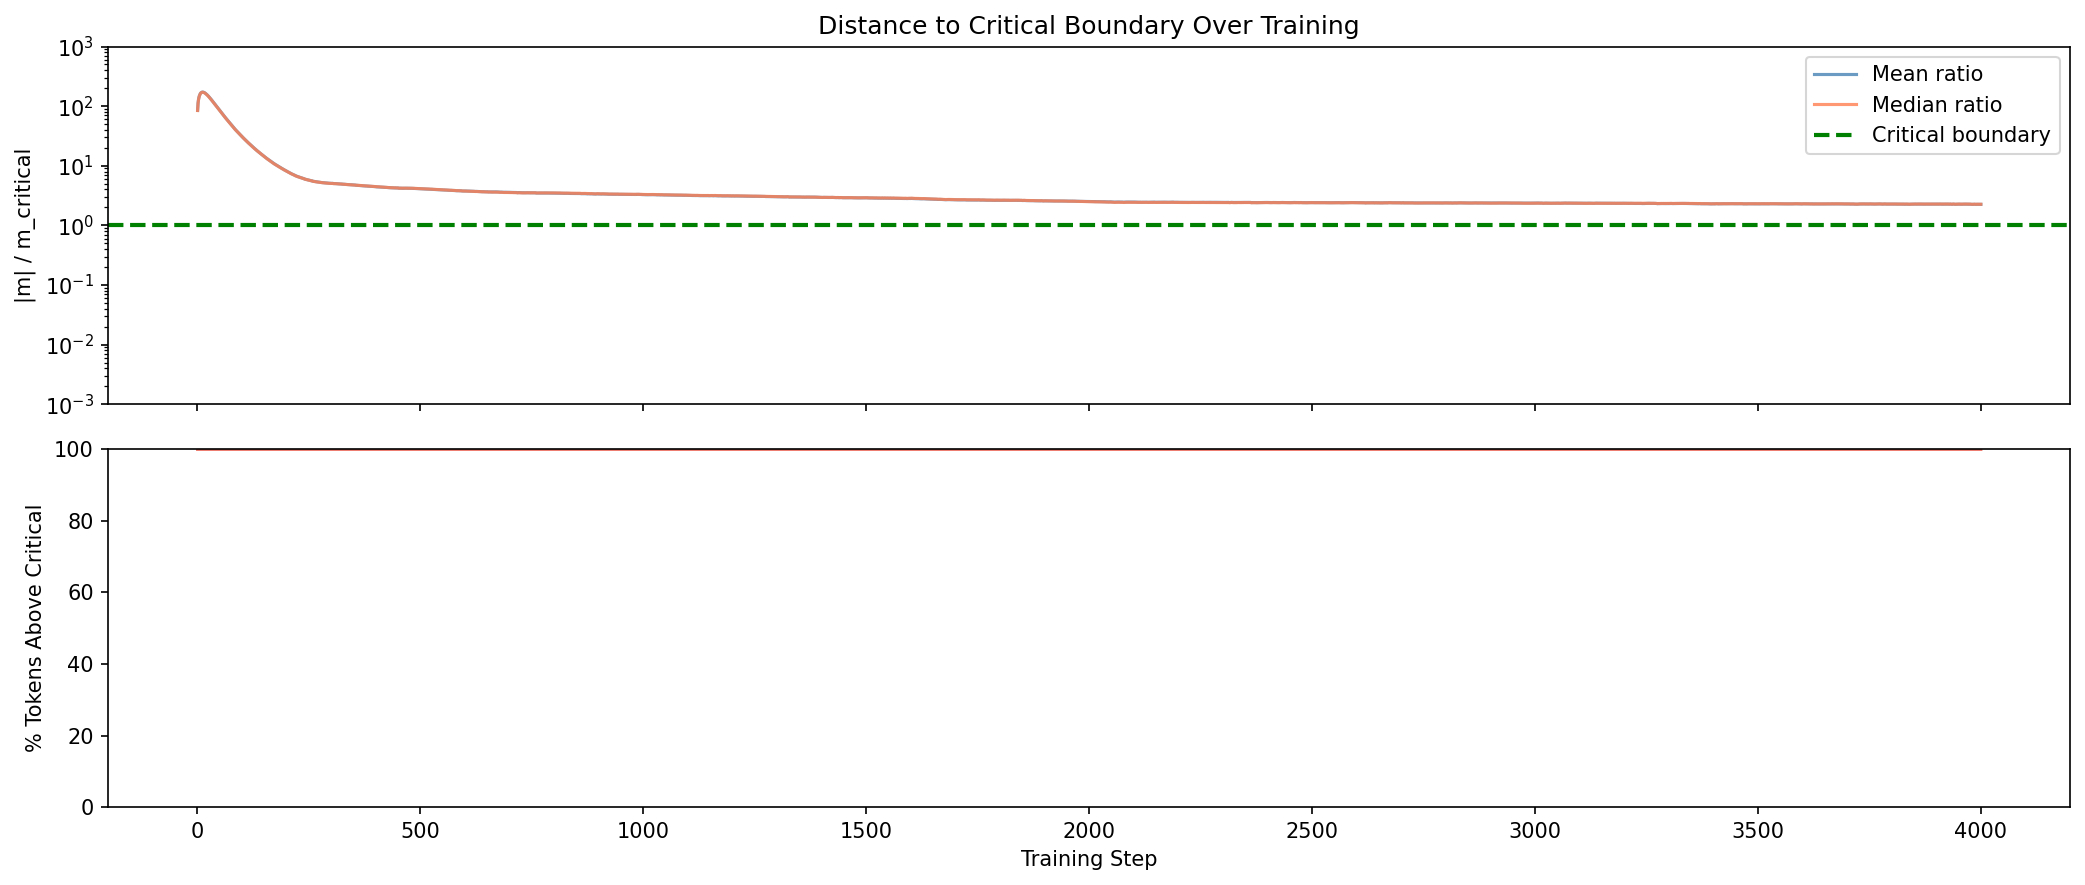

In [23]:
# For each token at each timestep, compute the ratio |m| / m_critical
# Ratio > 1 means above critical (can hop), < 1 means below (frozen)

m_critical_per_token = critical_m(sqrt_v_mean, ulp_mean)  # (4000, 3699)
ratio_to_critical = m_norm / m_critical_per_token  # (4000, 3699)

# Summary statistics over time
mean_ratio = ratio_to_critical.mean(dim=1).numpy()
median_ratio = ratio_to_critical.median(dim=1).values.numpy()
frac_above = (ratio_to_critical > 1).float().mean(dim=1).numpy()

steps = np.arange(1, n_steps + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=FIGSIZE_WIDE, dpi=DPI, sharex=True)

# Top: ratio over time
ax1.semilogy(steps, mean_ratio, label='Mean ratio', color='steelblue', alpha=0.8)
ax1.semilogy(steps, median_ratio, label='Median ratio', color='coral', alpha=0.8)
ax1.axhline(1.0, color='green', linestyle='--', linewidth=2, label='Critical boundary')
ax1.set_ylabel('|m| / m_critical')
ax1.set_title('Distance to Critical Boundary Over Training')
ax1.legend(loc='upper right')
ax1.set_ylim(1e-3, 1e3)

# Bottom: fraction above critical
ax2.plot(steps, frac_above * 100, color='#e74c3c', alpha=0.8)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('% Tokens Above Critical')
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

In [24]:
print("=" * 60)
print("PHASE SPACE STATISTICS")
print("=" * 60)

# When does median ratio cross below 1?
below_critical = np.where(median_ratio < 1)[0]
if len(below_critical) > 0:
    print(f"Median ratio crosses below critical at step {below_critical[0] + 1}")

# When does fraction above drop below various thresholds?
for thresh in [50, 10, 1]:
    idx = np.where(frac_above * 100 < thresh)[0]
    if len(idx) > 0:
        print(f"Fraction above critical drops below {thresh}% at step {idx[0] + 1}")

print(f"\nFinal state (step 4000):")
print(f"  Mean ratio to critical: {mean_ratio[-1]:.4f}")
print(f"  Median ratio to critical: {median_ratio[-1]:.4f}")
print(f"  Fraction above critical: {frac_above[-1]*100:.2f}%")

PHASE SPACE STATISTICS

Final state (step 4000):
  Mean ratio to critical: 2.2520
  Median ratio to critical: 2.2603
  Fraction above critical: 100.00%
